In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import spectral
import spectral.io.envi as envi

### 反射率へ変換
$R = ((I_{3.0} - D_{3.0}) / 3.0) / ((W_{2.5} - D_{2.5}) / 2.5)$
- R : 反射率スペクトル
- I : サンプルの反射強度スペクトル
- W : ホワイトボードの反射スペクトル
- D : Darkデータ（カメラのノイズ）

In [2]:
def load(name: str):
    dark30_intensity = envi.open(r"raw_data\dark.3.hdr", r"raw_data\dark.3.raw")
    dark25_intensity = envi.open(r"raw_data\dark.2.5.hdr", r"raw_data\dark.2.5.raw")
    white25_intensity = envi.open(r"raw_data\white_2.5.hdr", r"raw_data\white_2.5.raw")
    wood_intensity = envi.open(fr"raw_data\{name}.hdr", fr"raw_data\{name}.raw")

    D30 = np.array(dark30_intensity.load())
    D25 = np.array(dark25_intensity.load())
    W25 = np.array(white25_intensity.load())
    I30 = np.array(wood_intensity.load())

    wave =wood_intensity.metadata['wavelength']
    wave=np.array(wave,dtype=np.float32)

    mask = wave < 2200 # 2200 nm 以上をカット.
    D30 = D30[:, :, mask]
    D25 = D25[:, :, mask]
    W25 = W25[:, :, mask]
    I30 = I30[:, :, mask]

    R = ((I30 - D30)/3.0) / ((W25 - D25)/2.5)
    return R

### 大津の二値化

In [3]:
from sklearn.decomposition import PCA
from skimage.filters import threshold_otsu

def bgmask(data):
    pca = PCA(n_components=1)
    H, W, C = data.shape
    data_pca = pca.fit_transform(data.reshape(-1, C))
    pc_images = data_pca.reshape((H, W, 1))

    binary_image = (pc_images > threshold_otsu(pc_images)).astype(int)
    
    return binary_image

In [4]:
name_list = ['s1', 's2_2_1', 's2_2_2', 's3', 's4_2_1', 's4_2_2']
data_list = []
for name in name_list:
    data = load(name)
    data_list.append(data)

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


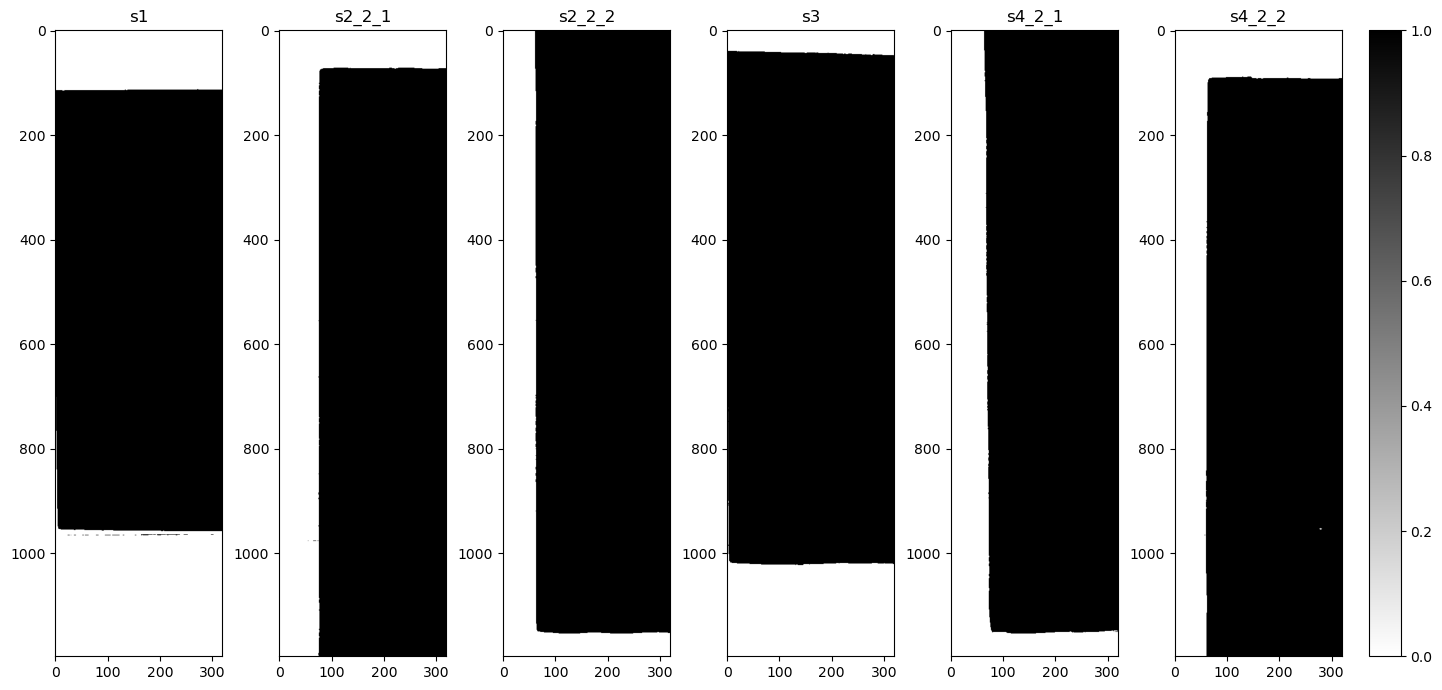

In [5]:
labels = []
fig, ax = plt.subplots(1, 6, figsize=(15, 7))
ax = ax.flatten()
for i, name, data in zip(np.arange(6), name_list, data_list):
    label = bgmask(data)
    labels.append(label)
    im = ax[i].imshow(label, cmap='binary')
    ax[i].set_title(fr'{name}')
plt.tight_layout(rect=[0, 0, 0.96, 1])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)

### モフォロジー演算

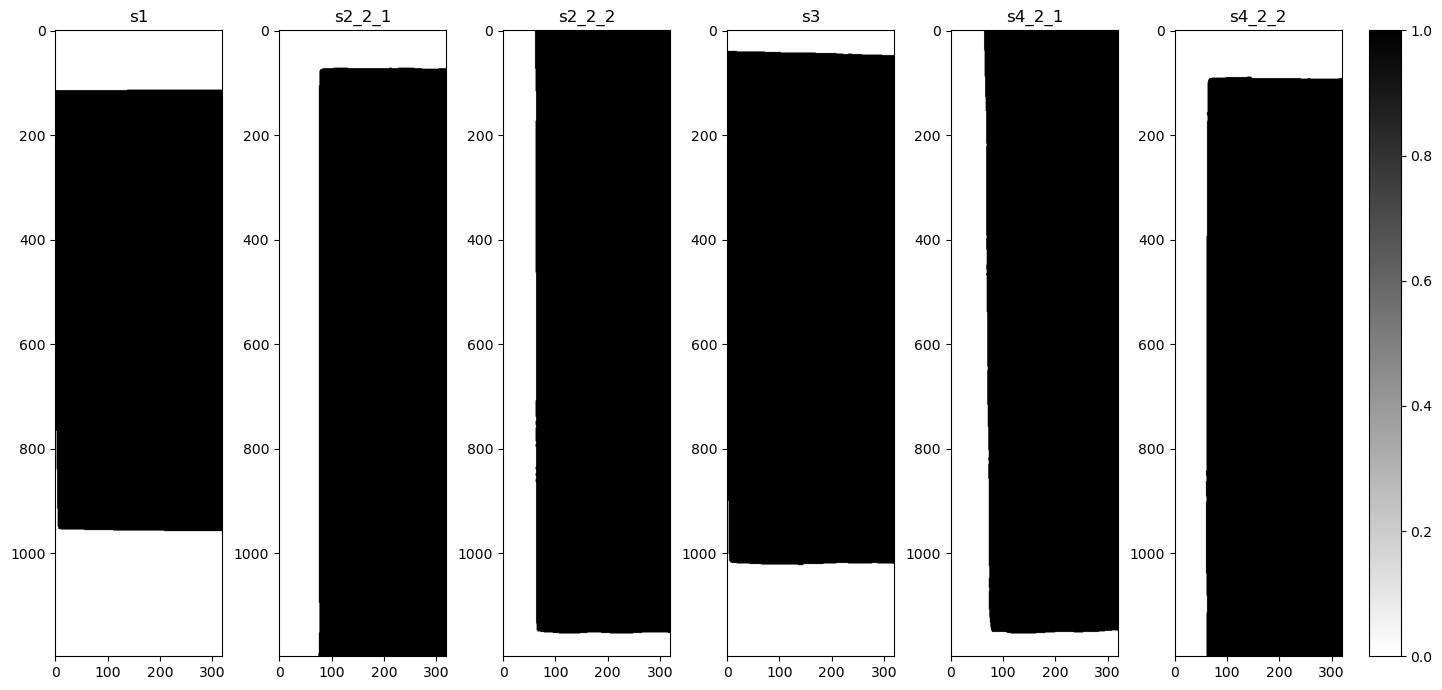

In [6]:
def label_denoise(data):
    data_uint8 = data.astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)

    opened = cv2.morphologyEx(data_uint8, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    return closed


labels_denoised = []
fig, ax = plt.subplots(1, 6, figsize=(15, 7))
ax = ax.flatten()
for i, name, label in zip(np.arange(6), name_list, labels):
    data = label_denoise(label)
    labels_denoised.append(data)
    im = ax[i].imshow(data, cmap='binary')
    ax[i].set_title(fr'{name}')
plt.tight_layout(rect=[0, 0, 0.96, 1])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)

### マスク内に完全に含まれる最大長方形

In [7]:
def maximal_rectangle(mask):
    """
    mask: 2値 ndarray (H, W), dtype=bool or 0/1
    return: (top, left, height, width) 最大長方形の座標
    """

    if mask.dtype != bool:
        mask = mask.astype(bool)

    H, W = mask.shape
    max_area = 0
    max_rect = (0, 0, 0, 0)

    height = np.zeros(W, dtype=int)

    for i in range(H):
        for j in range(W):
            if mask[i, j]:
                height[j] += 1
            else:
                height[j] = 0

        # histogramで最大長方形を計算
        area, left, right, h = largest_rectangle_in_histogram(height)
        if area > max_area:
            max_area = area
            max_rect = (i - h + 1, left, h, right - left + 1)

    return max_rect

def maximal_rectangle_with_margin(mask, margin=5):
    rect = maximal_rectangle(mask)
    top, left, height, width = rect

    # 左右のマージンを考慮して調整
    new_left = left + margin
    new_width = width - 2 * margin

    # 負の値や範囲外を防ぐクリップ
    new_left = max(new_left, 0)
    new_width = max(new_width, 1)  # 幅は最低1ピクセル確保

    # 右端が画像幅を超えないように調整
    img_width = mask.shape[1]
    if new_left + new_width > img_width:
        new_width = img_width - new_left

    return (top, new_left, height, new_width)


def largest_rectangle_in_histogram(heights):
    stack = []
    max_area = 0
    left_index = 0
    right_index = 0
    height = 0
    heights = np.append(heights, 0)
    for i, h in enumerate(heights):
        start = i
        while stack and stack[-1][1] > h:
            index, height_ = stack.pop()
            area = height_ * (i - index)
            if area > max_area:
                max_area = area
                left_index = index
                right_index = i - 1
                height = height_
            start = index
        stack.append((start, h))
    return max_area, left_index, right_index, height

def create_rect_mask(shape, rect):
    mask = np.zeros(shape, dtype=np.uint8)
    top, left, height, width = rect
    mask[top:top+height, left:left+width] = 1
    return mask

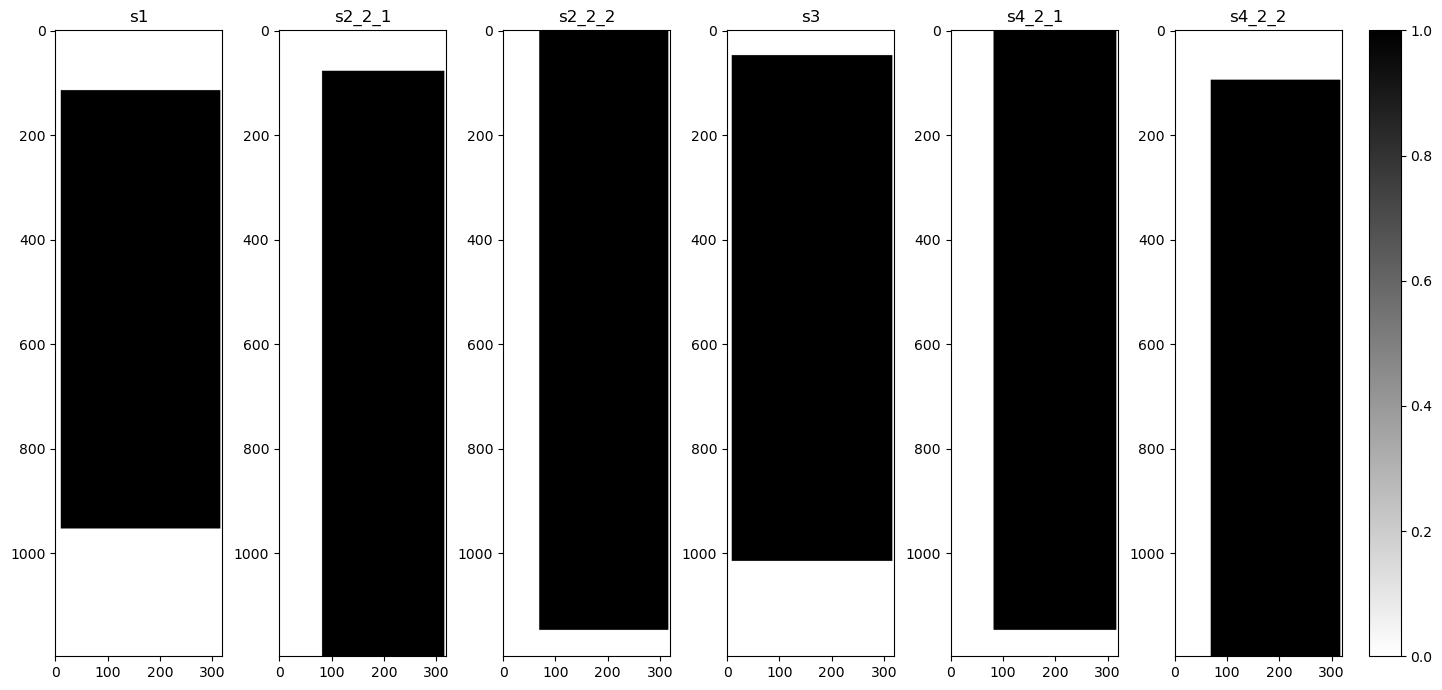

In [8]:
labels_denoised_new = []
fig, ax = plt.subplots(1, 6, figsize=(15, 7))
ax = ax.flatten()
for i, name, label in zip(np.arange(6), name_list, labels_denoised):
    rect = maximal_rectangle_with_margin(label)
    rect_mask = create_rect_mask(label.shape, rect)
    labels_denoised_new.append(rect_mask)
    im = ax[i].imshow(rect_mask, cmap='binary')
    ax[i].set_title(fr'{name}')
plt.tight_layout(rect=[0, 0, 0.96, 1])
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)


### SNV処理

In [9]:
def snv(data):
    mean = data.mean(axis=2, keepdims=True)
    std = data.std(axis=2, ddof=1, keepdims=True)
    std[std == 0] = 1e-8 # 0 割り回避.
    return (data - mean) / std

In [10]:
data_snv_list = []
for data in data_list:
    data_snv_list.append(snv(data))

### 保存

In [11]:
wood_intensity = envi.open(r"raw_data\s1.hdr", r"raw_data\s1.raw")
wave =wood_intensity.metadata['wavelength']
wave=np.array(wave,dtype=np.float32)
mask = wave < 2200 
wave_cut = wave[mask]
wavenumber = 10**7 / wave_cut
np.save(r'Data_preprocessed\wavenumber.npy', wavenumber)

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [12]:
for name, bgmask, img, img_snv in zip(name_list, labels_denoised_new, data_list, data_snv_list):
    np.save(fr'Data_preprocessed\{name}_mask.npy', bgmask)
    np.save(fr'Data_preprocessed\{name}.npy', img)
    np.save(fr'Data_preprocessed\{name}_snv.npy', img_snv)

---

In [13]:
name_list = ['s1', 's2_2_1', 's2_2_2', 's3', 's4_2_1', 's4_2_2']
def load_data(name: str):
    return np.load(fr'Data_preprocessed\{name}.npy'), np.load(fr'Data_preprocessed\{name}_snv.npy'), np.load(fr'Data_preprocessed\{name}_mask.npy')

In [14]:
data_list = []
data_snv_list = []
mask_list = []
for name in name_list:
    data, data_snv, mask = load_data(name)
    data_list.append(data)
    data_snv_list.append(data_snv)
    mask_list.append(mask)

In [15]:
hinoki = []
hinoki_snv = []
for data, data_snv, mask in zip(data_list, data_snv_list, mask_list):
    H, W, C = data.shape
    wood = data.reshape(-1, C)[mask.reshape(-1) == 1] # 1 が木材
    wood_snv = data_snv.reshape(-1, C)[mask.reshape(-1) == 1]
    hinoki.append(wood)
    hinoki_snv.append(wood_snv)
hinoki = np.concatenate(hinoki, axis=0)
hinoki_snv = np.concatenate(hinoki_snv, axis=0)

In [17]:
np.save(r'Data_preprocessed\hinoki.npy', hinoki)
np.save(r'Data_preprocessed\hinoki_snv.npy', hinoki_snv)